In [1]:
# import tensorflow as tf
# import keras
import pandas as pd
import numpy as np
import os
import sys
import glob
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

import lightgbm as lgb
# import xgboost as xgb
import time
import datetime
# from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
# from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

from scipy.signal import hilbert
from scipy.signal import hann
from scipy.signal import convolve
from scipy import stats
from sklearn.kernel_ridge import KernelRidge
from tqdm import tqdm_notebook
import seaborn as sns

from sklearn.model_selection import train_test_split

import pickle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score, accuracy_score
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score

In [3]:
pd.set_option('display.max_columns', None)

In [2]:
players = pd.read_csv('/home/ryan/ml/tennis_ml/tennis_atp/atp_players.csv', 
                      header=None, 
                      names=['player_id', 'first_name', 'last_name', 'hand', 'birthday','country_code'])

In [3]:
players

,player_id,first_name,last_name,hand,birthday,country_code
0,100001,Gardnar,Mulloy,R,19131122.0,USA
1,100002,Pancho,Segura,R,19210620.0,ECU
2,100003,Frank,Sedgman,R,19271002.0,AUS
3,100004,Giuseppe,Merlo,R,19271011.0,ITA
4,100005,Richard Pancho,Gonzales,R,19280509.0,USA
...,...,...,...,...,...,...
54892,209858,Vladimir,Osminkin,U,NaN,RUS
54893,209859,Rostislav,Galfinger,U,20021112.0,KAZ
54894,209860,Ignacio,Buse,U,20040325.0,PER
54895,209861,Maj,Tomac,U,20010504.0,SLO


In [4]:
#read all CSVs here and concatenate to form one dataframe
# df = pd.read_csv('/home/ryan/ml/tennis_ml/tennis_atp/atp_matches_2019.csv')

#enter years form which to take data: [start, end]
years = [2000, 2019]
df = pd.DataFrame()

for year in np.arange(years[0], years[1]+1):
    df_year = pd.read_csv(f'/home/ryan/ml/tennis_ml/tennis_atp/atp_matches_{year}.csv')
    df = pd.concat([df,df_year])

In [5]:
df

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
0,2000-301,Auckland,Hard,32,A,20000110,1,103163,1,NaN,...,55.0,39.0,29.0,17.0,4.0,7.0,11.0,1612.0,63.0,595.0
1,2000-301,Auckland,Hard,32,A,20000110,2,102607,NaN,Q,...,32.0,25.0,18.0,12.0,3.0,6.0,211.0,157.0,49.0,723.0
2,2000-301,Auckland,Hard,32,A,20000110,3,103252,NaN,NaN,...,33.0,20.0,7.0,8.0,7.0,11.0,48.0,726.0,59.0,649.0
3,2000-301,Auckland,Hard,32,A,20000110,4,103507,7,NaN,...,43.0,29.0,14.0,10.0,6.0,8.0,45.0,768.0,61.0,616.0
4,2000-301,Auckland,Hard,32,A,20000110,5,102103,NaN,Q,...,46.0,34.0,18.0,12.0,5.0,9.0,167.0,219.0,34.0,873.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2776,2019-M-DC-2019-QLS-M-SUI-RUS-01,Davis Cup QLS R1: SUI vs RUS,Hard,4,D,20190201,2,111575,NaN,NaN,...,47.0,32.0,14.0,10.0,5.0,8.0,11.0,2880.0,362.0,56.0
2777,2019-M-DC-2019-QLS-M-SUI-RUS-01,Davis Cup QLS R1: SUI vs RUS,Hard,4,D,20190201,4,111575,NaN,NaN,...,94.0,65.0,27.0,17.0,15.0,17.0,11.0,2880.0,142.0,389.0
2778,2019-M-DC-2019-QLS-M-SWE-COL-01,Davis Cup QLS R1: SWE vs COL,Clay,4,D,20190201,1,105053,NaN,NaN,...,33.0,20.0,7.0,9.0,1.0,5.0,251.0,190.0,116.0,485.0
2779,2019-M-DC-2019-QLS-M-SWE-COL-01,Davis Cup QLS R1: SWE vs COL,Clay,4,D,20190201,2,123755,NaN,NaN,...,31.0,14.0,9.0,7.0,2.0,6.0,228.0,224.0,194.0,267.0


In [6]:
list(df.columns.values)

['tourney_id',
 'tourney_name',
 'surface',
 'draw_size',
 'tourney_level',
 'tourney_date',
 'match_num',
 'winner_id',
 'winner_seed',
 'winner_entry',
 'winner_name',
 'winner_hand',
 'winner_ht',
 'winner_ioc',
 'winner_age',
 'loser_id',
 'loser_seed',
 'loser_entry',
 'loser_name',
 'loser_hand',
 'loser_ht',
 'loser_ioc',
 'loser_age',
 'score',
 'best_of',
 'round',
 'minutes',
 'w_ace',
 'w_df',
 'w_svpt',
 'w_1stIn',
 'w_1stWon',
 'w_2ndWon',
 'w_SvGms',
 'w_bpSaved',
 'w_bpFaced',
 'l_ace',
 'l_df',
 'l_svpt',
 'l_1stIn',
 'l_1stWon',
 'l_2ndWon',
 'l_SvGms',
 'l_bpSaved',
 'l_bpFaced',
 'winner_rank',
 'winner_rank_points',
 'loser_rank',
 'loser_rank_points']

#### create player dictionary

In [7]:
#unique ids in the csv
ids = pd.concat([df['winner_id'], df['loser_id']]).unique()
ids

array([103163, 102607, 103252, ..., 126328, 208103, 200343])

In [ ]:
###iterate through player ids and collect features

#instantiate a new dictionary to keep track of player stats
#this will be useful for diffing them later to create input-target pairs
pid_dict = {}
    
for target_pid in tqdm_notebook(ids):
# for target_pid in ids:
    ### get features from whether the target player won or lost
    df2 = df[(df.loc[:,'winner_id'] == target_pid ) | (df.loc[:,'loser_id'] == target_pid)]

    ###create target column here
    y = [1 if pid==target_pid else 0 for pid in df2.winner_id.values]
    y = pd.DataFrame(data=y, columns=['target'])

    ###switch up the dataframe to account for losses since after 
    ###taking target into account, we dont care about winner/loser specific columns
    swapped_features = ['ace', 'df', 'svpt', '1stIn', '1stWon', '2ndWon', 'SvGms', 'bpSaved', 'bpFaced']
#     swapped_features = ['ace', 'df', 'bpSaved', 'bpFaced']
    for swapFeat in swapped_features:
        df2.loc[(y.target.values == 0), f'w_{swapFeat}'] = df2.loc[(y.target.values == 0), f'l_{swapFeat}']

    ### sort by tournament date and match number so features are sequential/time-dependant
    df2 = df2.sort_values(['tourney_date', 'match_num'], ascending=[True, True])

    ###extract stats from features
    segments = df2.shape[0]
    features = ['w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_SvGms', 'w_bpSaved', 'w_bpFaced']
#     features = ['w_ace', 'w_df', 'w_bpSaved', 'w_bpFaced']
    x_tr = extract_stats(df2, segments, features)

    df2.reset_index(drop=True, inplace=True)
    x_tr.reset_index(drop=True, inplace=True)
    y.reset_index(drop=True, inplace=True)

    x_tr = pd.concat([df2['tourney_date'], df2['match_num'], y['target'], x_tr], axis=1)

    # ### save to dictionary by PID
    pid_dict.update({f'{target_pid}' : x_tr})

In [8]:
#pickle out the player dicitonary
# pickle.dump(pid_dict, open( "/home/ryan/ml/tennis_ml/tennis-ml/saved_dictionaries/player_dict_030120.pckl", "wb" ) )
pid_dict = pickle.load( open( "/home/ryan/ml/tennis_ml/tennis-ml/saved_dictionaries/player_dict_030120.pckl", "rb" ) )

In [9]:
len(pid_dict)

2279

#### create input-target pairs

In [28]:
#tournament date cutoff for validation data
val_tourney_date = 20180501
test_tourney_date = 20190501

#number of rows before/equal to cutoff date
train_rows = (df['tourney_date'] < val_tourney_date).value_counts()[1]
val_rows = ((df['tourney_date'] >= val_tourney_date) & (df['tourney_date'] < test_tourney_date)).value_counts()[1]
test_rows = (df['tourney_date'] >= test_tourney_date).value_counts()[1]

print(f"training samples: {train_rows}")
print(f"val samples: {val_rows}")
print(f"test samples: {test_rows}")

#number of statistical measures taken across features
num_stats = pid_dict['100644'].shape[1]-3
# print(num_stats)

### iterate throught the main dataframe to link up player-ids
### and pull information from the respective dictionary index to form input-target pairs
x_train = np.empty(shape=(int(train_rows*2), num_stats))
y_train = np.empty(shape=(int(train_rows*2), 1))

x_val = np.empty(shape=(int(val_rows*2), num_stats))
y_val = np.empty(shape=(int(val_rows*2), 1))

x_test = np.empty(shape=(int(test_rows*2), num_stats))
y_test = np.empty(shape=(int(test_rows*2), 1))

### get features from whether the target player won or lost
df = df.sort_values(['tourney_date', 'match_num'], ascending=[True, True])

#initialize counters
j = 0
k = 0
l = 0

#loop through each row in the original dataframe
for winner_id, loser_id, tdate, match_num in tqdm_notebook(zip(df.winner_id.values, df.loser_id.values, df.tourney_date.values, df.match_num.values)):
    
    #extract features from player maps
    features_w = np.asarray(pid_dict[f'{winner_id}'].loc[(pid_dict[f'{winner_id}']['tourney_date'] == tdate) & (pid_dict[f'{winner_id}']['match_num'] == match_num)].loc[:, 'ace_mean':])[:1,:]
    features_l = np.asarray(pid_dict[f'{loser_id}'].loc[(pid_dict[f'{loser_id}']['tourney_date'] == tdate) & (pid_dict[f'{loser_id}']['match_num'] == match_num)].loc[:, 'ace_mean':])[:1,:]

    #add to train or validation set based on cutoff date chosen
    if tdate < val_tourney_date:
        ### add to x_train array
        #diff the features from winner to loser and count as a win
        x_train[j,:] = features_w - features_l
        y_train[j,0] = 1.0

        #diff the features from loser to winner and count as a loss
        x_train[j+1,:] = features_l - features_w
        y_train[j+1,0] = 0.0
        
        #increment counter
        j+=2
    elif (tdate >= val_tourney_date) & (tdate < test_tourney_date):
        ### add to x_val array
        x_val[k,:] = features_w - features_l
        y_val[k,0] = 1.0

        #diff the features from loser to winner and count as a loss
        x_val[k+1,:] = features_l - features_w
        y_val[k+1,0] = 0.0
        
        #increment counter
        k+=2
    else:
        ### add to x_val array
        x_test[l,:] = features_w - features_l
        y_test[l,0] = 1.0

        #diff the features from loser to winner and count as a loss
        x_test[l+1,:] = features_l - features_w
        y_test[l+1,0] = 0.0
        
        #increment counter
        l+=2

training samples: 57256
val samples: 2734
test samples: 1684


#### Multi-class first set score prediction

In [334]:
#tournament date cutoff for validation data
val_tourney_date = 20180501
test_tourney_date = 20190501

#number of rows before/equal to cutoff date
train_rows = (df['tourney_date'] < val_tourney_date).value_counts()[1]
val_rows = ((df['tourney_date'] >= val_tourney_date) & (df['tourney_date'] < test_tourney_date)).value_counts()[1]
test_rows = (df['tourney_date'] >= test_tourney_date).value_counts()[1]

print(f"training samples: {train_rows}")
print(f"val samples: {val_rows}")
print(f"test samples: {test_rows}")

#number of statistical measures taken across features
num_stats = pid_dict['100644'].shape[1]-3
# print(num_stats)

num_classes = 14

### iterate throught the main dataframe to link up player-ids
### and pull information from the respective dictionary index to form input-target pairs
x_train = np.empty(shape=(int((train_rows*2)), num_stats))
y_train = np.zeros(shape=(int((train_rows*2)), 1), dtype=np.int32)

x_val = np.empty(shape=(int((val_rows*2)), num_stats))
y_val = np.zeros(shape=(int((val_rows*2)), 1), dtype=np.int32)

x_test = np.empty(shape=(int((test_rows*2)), num_stats))
y_test = np.zeros(shape=(int((test_rows*2)), 1), dtype=np.int32)

print(x_train.shape)

# x_train = np.empty(shape=(0, num_stats))
# y_train = np.empty(shape=(0, 1), dtype=np.int32)

# x_val = np.empty(shape=(0, num_stats))
# y_val = np.empty(shape=(0, 1), dtype=np.int32)

# x_test = np.empty(shape=(0, num_stats))
# y_test = np.empty(shape=(0, 1), dtype=np.int32)

### get features from whether the target player won or lost
df = df.sort_values(['tourney_date', 'match_num'], ascending=[True, True])

#initialize counters
j = 0
k = 0
l = 0

#first round enum
first_round=0

invalid_scores = []

#loop through each row in the original dataframe
for score, winner_id, loser_id, tdate, match_num in tqdm_notebook(zip(df.score.values, df.winner_id.values, df.loser_id.values, df.tourney_date.values, df.match_num.values)):
    
    #extract features from player maps
    features_w = np.asarray(pid_dict[f'{winner_id}'].loc[(pid_dict[f'{winner_id}']['tourney_date'] == tdate) & (pid_dict[f'{winner_id}']['match_num'] == match_num)].loc[:, 'ace_mean':])[:1,:]
    features_l = np.asarray(pid_dict[f'{loser_id}'].loc[(pid_dict[f'{loser_id}']['tourney_date'] == tdate) & (pid_dict[f'{loser_id}']['match_num'] == match_num)].loc[:, 'ace_mean':])[:1,:]

#     print(score)
    
    #get multiclass targets
    try:
#         if (score != 'W/O'):
        score = str(score)
        score1, score2 = score.split(' ')[first_round].split('-')
        if score1 > score2:
            winner_first_set_score = score1
            loser_first_set_score = score2
        else:
            winner_first_set_score = score2
            loser_first_set_score = score1

        if '(' in loser_first_set_score:
            loser_first_set_score = loser_first_set_score[:1]                                 
        if '(' in winner_first_set_score:
            winner_first_set_score = winner_first_set_score[:1]

        winner_first_set_score = np.asarray(winner_first_set_score, dtype=np.int32)
        loser_first_set_score = np.asarray(loser_first_set_score, dtype=np.int32)

        
        if get_cate_val(winner_first_set_score, loser_first_set_score, winner_entry=True) == -1:
            print(score)
            print(winner_first_set_score)
            print(loser_first_set_score)
#             break
        
        #add to train or validation set based on cutoff date chosen
        if tdate < val_tourney_date:
            ### add to x_train array
            #diff the features from winner to loser and count as a win
            x_train[j,:] = features_w - features_l
            y_train[j,0] = get_cate_val(winner_first_set_score, loser_first_set_score, winner_entry=True)

            #diff the features from loser to winner and count as a loss
            x_train[j+1,:] = features_l - features_w
            y_train[j+1,0] = get_cate_val(winner_first_set_score, loser_first_set_score, winner_entry=False)

            #increment counter
            j+=2
        elif (tdate >= val_tourney_date) & (tdate < test_tourney_date):
            ### add to x_val array
            x_val[k,:] = features_w - features_l
            y_val[k,0] = get_cate_val(winner_first_set_score, loser_first_set_score, winner_entry=True)

            #diff the features from loser to winner and count as a loss
            x_val[k+1,:] = features_l - features_w
            y_val[k+1,0] = get_cate_val(winner_first_set_score, loser_first_set_score, winner_entry=False)

            #increment counter
            k+=2
        else:
            ### add to x_val array
            x_test[l,:] = features_w - features_l
            y_test[l,0] = get_cate_val(winner_first_set_score, loser_first_set_score, winner_entry=True)

            #diff the features from loser to winner and count as a loss
            x_test[l+1,:] = features_l - features_w
            y_test[l+1,0] = get_cate_val(winner_first_set_score, loser_first_set_score, winner_entry=False)

            #increment counter
            l+=2

    except(ValueError):
#         print(score)
#         break

        #add to train or validation set based on cutoff date chosen
        if tdate < val_tourney_date:
            ### add to x_train array
            #diff the features from winner to loser and count as a win
            x_train[j,:] = features_w - features_l
            y_train[j,0] = -1

            #diff the features from loser to winner and count as a loss
            x_train[j+1,:] = features_l - features_w
            y_train[j+1,0] = -1

            #increment counter
            j+=2
        elif (tdate >= val_tourney_date) & (tdate < test_tourney_date):
            ### add to x_val array
            x_val[k,:] = features_w - features_l
            y_val[k,0] = -1

            #diff the features from loser to winner and count as a loss
            x_val[k+1,:] = features_l - features_w
            y_val[k+1,0] = -1

            #increment counter
            k+=2
        else:
            ### add to x_val array
            x_test[l,:] = features_w - features_l
            y_test[l,0] = -1

            #diff the features from loser to winner and count as a loss
            x_test[l+1,:] = features_l - features_w
            y_test[l+1,0] = -1

            #increment counter
            l+=2

        invalid_scores.append(score)
        continue

training samples: 57256
val samples: 2734
test samples: 1684
(114512, 509)


3-0 RET
3
0
4-1 RET
4
1
2-4 RET
4
2
4-1 RET
4
1
5-0 RET
5
0
5-0 RET
5
0
3-3 RET
3
3
5-3 DEF
5
3
3-0 RET
3
0
3-2 RET
3
2
4-1 RET
4
1
5-3 RET
5
3
3-2 RET
3
2
1-0 RET
1
0
4-1 RET
4
1
5-4 RET
5
4
1-2 RET
2
1
4-0 RET
4
0
3-2 RET
3
2
1-0 RET
1
0
3-3 RET
3
3
1-1 RET
1
1
4-3 RET
4
3
4-0 RET
4
0
4-1 RET
4
1
2-2 RET
2
2
3-1 RET
3
1
4-2 RET
4
2
3-0 RET
3
0
4-1 RET
4
1
5-2 RET
5
2
3-4 DEF
4
3
4-0 RET
4
0
5-0 RET
5
0
2-1 RET
2
1
3-4 RET
4
3
4-3 RET
4
3
4-1 RET
4
1
3-1 RET
3
1
4-5 RET
5
4
3-2 RET
3
2
5-2 RET
5
2
5-0 RET
5
0
5-2 RET
5
2
5-2 RET
5
2
5-1 RET
5
1
1-1 RET
1
1
4-1 RET
4
1
4-2 RET
4
2
1-2 RET
2
1
0-1 RET
1
0
6-6(0) RET
6
6
4-0 RET
4
0
2-1 RET
2
1
4-3 RET
4
3
5-1 RET
5
1
3-0 RET
3
0
5-3 RET
5
3
3-0 RET
3
0
3-1 RET
3
1
4-0 RET
4
0
2-1 RET
2
1
5-2 RET
5
2
5-4 RET
5
4
4-1 RET
4
1
1-2 RET
2
1
3-0 RET
3
0
2-1 RET
2
1
4-3 RET
4
3
4-1 RET
4
1
4-3 RET
4
3
2-3 RET
3
2
5-1 RET
5
1
5-1 RET
5
1
4-1 RET
4
1
5-4 RET
5
4
3-3 RET
3
3
3-2 RET
3
2
5-1 RET
5
1
4-0 RET
4
0
0-3 Played and abandoned
3
0
4-2 RET


In [169]:
def get_cate_val(winner_score, loser_score, winner_entry):
    if winner_entry:
        if (winner_score == 6) & (loser_score == 0):
            cat_class = 0
        elif (winner_score == 6) & (loser_score == 1):
            cat_class = 1
        elif (winner_score == 6) & (loser_score == 2):
            cat_class = 2
        elif (winner_score == 6) & (loser_score == 3):
            cat_class = 3
        elif (winner_score == 6) & (loser_score == 4):
            cat_class = 4
        elif (winner_score == 7) & (loser_score == 5):
            cat_class = 5
        elif (winner_score == 7) & (loser_score == 6):
            cat_class = 6
        else:
            cat_class = -1
    else:
        if (winner_score == 6) & (loser_score == 0):
            cat_class = 7
        elif (winner_score == 6) & (loser_score == 1):
            cat_class = 8
        elif (winner_score == 6) & (loser_score == 2):
            cat_class = 9
        elif (winner_score == 6) & (loser_score == 3):
            cat_class = 10
        elif (winner_score == 6) & (loser_score == 4):
            cat_class = 11
        elif (winner_score == 7) & (loser_score == 5):
            cat_class = 12
        elif (winner_score == 7) & (loser_score == 6):
            cat_class = 13
        else:
            cat_class = -1
            
    return cat_class


In [335]:
len(invalid_scores)

314

In [336]:
x_train = np.delete(x_train, np.argwhere(y_train[:,0] == -1), axis=0)
x_val = np.delete(x_val, np.argwhere(y_val[:,0] == -1), axis=0)
x_test = np.delete(x_test, np.argwhere(y_test[:,0] == -1), axis=0)

In [337]:
y_train = np.delete(y_train, np.argwhere(y_train[:,0] == -1), axis=0)
y_val = np.delete(y_val, np.argwhere(y_val[:,0] == -1), axis=0)
y_test = np.delete(y_test, np.argwhere(y_test[:,0] == -1), axis=0)

In [338]:
x_train.shape

(113270, 509)

In [339]:
y_train.shape

(113270, 1)

# LGBM developement

### Random searh for hyperparameter optimization

In [29]:
#random search for hyperparameter optimization
param_test ={'num_leaves': sp_randint(15, 150), 
             'min_child_samples': sp_randint(100, 500), 
             'min_data_in_leaf': sp_randint(20,150), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100],
             'max_depth': [3, 4, 5, 6, 8, 12, 16, -1],
             'learning_rate': [0.1, 0.05, 0.01, 0.005],
             'bagging_freq': [3, 4, 5, 6, 7],
             'bagging_fraction': np.linspace(0.6, 0.95, 10)}

fit_params={"early_stopping_rounds": 30, 
            "eval_metric" : 'auc', 
            "eval_set" : [(x_val, y_val[:,0])],
            'eval_names': ['valid'],
            'verbose': 100,
            'categorical_feature': 'auto'}

In [30]:
#n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 5000 define only the absolute maximum

#This parameter defines the number of HP points to be tested
n_HP_points_to_test = 100

clf = lgb.LGBMClassifier(max_depth=-1, 
                         random_state=7, 
                         silent=True, 
                         metric='None', 
                         n_jobs=8, 
                         n_estimators=5000,
                         objective='binary')

gs = RandomizedSearchCV(estimator=clf, 
                        param_distributions=param_test, 
                        n_iter=n_HP_points_to_test,
                        scoring='roc_auc',
                        cv=3,
                        refit=True,
                        random_state=7,
                        verbose=True)

In [31]:
gs.fit(x_train, y_train[:,0], **fit_params)
print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[65]	valid's auc: 0.688103
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.685374
[200]	valid's auc: 0.694939
[300]	valid's auc: 0.700644
[400]	valid's auc: 0.706754
[500]	valid's auc: 0.713419
[600]	valid's auc: 0.718473
[700]	valid's auc: 0.722357
[800]	valid's auc: 0.726363
[900]	valid's auc: 0.729366
[1000]	valid's auc: 0.732078
[1100]	valid's auc: 0.734274
[1200]	valid's auc: 0.736073
[1300]	valid's auc: 0.737774
[1400]	valid's auc: 0.739546
[1500]	valid's auc: 0.740684
[1600]	valid's auc: 0.741809
[1700]	valid's auc: 0.743062
[1800]	valid's auc: 0.744166
[1900]	valid's auc: 0.745226
[2000]	valid's auc: 0.746154
[2100]	valid's auc: 0.747173
[2200]	valid's auc: 0.748069
[2300]	valid's auc: 0.748889
[2400]	valid's auc: 0.749826
[2500]	valid's auc: 0.750603
[2600]	valid's auc: 0.75141
[2700]	valid's auc: 0.75225
[2800]	valid's auc: 0.752905
[2900]	valid's 

KeyboardInterrupt: 

In [ ]:
print(gs.best_params_)

### Train with optimal params

In [ ]:
# using LGBM lib here
# link to original work: https://papers.nips.cc/paper/6907-lightgbm-a-highly-efficient-gradient-boosting-decision-tree.pdf

In [34]:
params = {'colsample_bytree': 0.7496764148510038,
          'min_child_samples': 260,
          'min_child_weight': 0.01,
          'min_data_in_leaf': 144,
          'num_leaves': 43,
          'reg_alpha': 7,
          'reg_lambda': 100,
          'subsample': 0.48389072037616415,
          'learning_rate': 0.01} 

model = lgb.LGBMClassifier(**params,
                           n_estimators = 3000,
                           n_jobs = 6, 
                           objective='binary')

model.fit(x_train, y_train[:,0],
          eval_set=[(x_train, y_train[:,0]), (x_val, y_val[:,0])],
          verbose=True,
          early_stopping_rounds=250)

[1]	valid_0's binary_logloss: 0.691747	valid_1's binary_logloss: 0.69196
Training until validation scores don't improve for 250 rounds
[2]	valid_0's binary_logloss: 0.690367	valid_1's binary_logloss: 0.690768
[3]	valid_0's binary_logloss: 0.688983	valid_1's binary_logloss: 0.6896
[4]	valid_0's binary_logloss: 0.687801	valid_1's binary_logloss: 0.688656
[5]	valid_0's binary_logloss: 0.686665	valid_1's binary_logloss: 0.687795
[6]	valid_0's binary_logloss: 0.685339	valid_1's binary_logloss: 0.686644
[7]	valid_0's binary_logloss: 0.684177	valid_1's binary_logloss: 0.68564
[8]	valid_0's binary_logloss: 0.682902	valid_1's binary_logloss: 0.684548
[9]	valid_0's binary_logloss: 0.681855	valid_1's binary_logloss: 0.683735
[10]	valid_0's binary_logloss: 0.680615	valid_1's binary_logloss: 0.68269
[11]	valid_0's binary_logloss: 0.679377	valid_1's binary_logloss: 0.681637
[12]	valid_0's binary_logloss: 0.678256	valid_1's binary_logloss: 0.680703
[13]	valid_0's binary_logloss: 0.67707	valid_1's bin

LGBMClassifier(boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.7496764148510038, importance_type='split',
               learning_rate=0.01, max_depth=-1, min_child_samples=260,
               min_child_weight=0.01, min_data_in_leaf=144, min_split_gain=0.0,
               n_estimators=3000, n_jobs=6, num_leaves=43, objective='binary',
               random_state=None, reg_alpha=7, reg_lambda=100, silent=True,
               subsample=0.48389072037616415, subsample_for_bin=200000,
               subsample_freq=0)

In [35]:
#validation set prediction @ 0.5 threshold
y_pred_val = model.predict(x_val)
print(f'Validation-set acc: {accuracy_score(y_val, y_pred_val)*100:0.2f}%')

Validation-set acc: 71.96%


In [36]:
#validation set prediction @ 0.5 threshold
y_pred_test = model.predict(x_test)
print(f'Hold-out Test-set acc: {accuracy_score(y_test, y_pred_test)*100:0.2f}%')

Hold-out Test-set acc: 71.26%


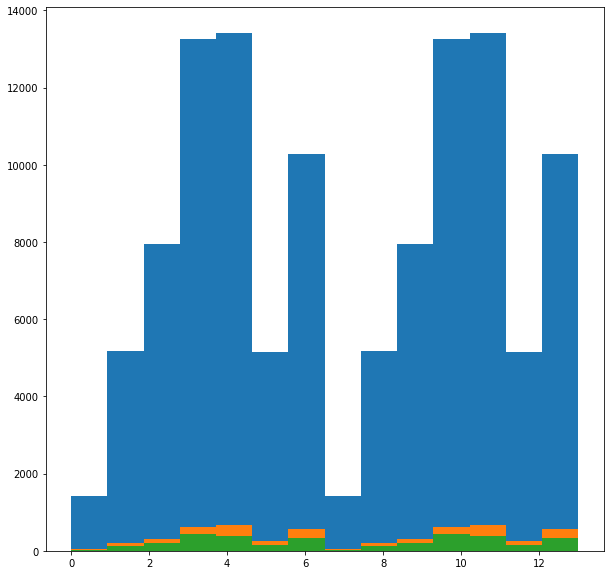

In [340]:
plt.figure(figsize=(10,10))
plt.hist(y_train[:,0], bins=14)
plt.hist(y_val[:,0], bins=14)
plt.hist(y_test[:,0], bins=14)
plt.show()

In [ ]:
params = {'colsample_bytree': 0.7496764148510038,
          'min_child_samples': 260,
          'min_child_weight': 0.1,
          'min_data_in_leaf': 144,
          'num_leaves': 43,
          'reg_alpha': 7,
          'reg_lambda': 100,
          'subsample': 0.48389072037616415,
          'learning_rate': 0.01,
          "objective" : "multiclass",
          "num_class" : 14,
          'class_weight': 'balanced'} 

model = lgb.LGBMClassifier(**params,
                           n_estimators = 2500,
                           n_jobs = 8)

model.fit(x_train, y_train[:,0],
          eval_set=[(x_train, y_train[:,0]), (x_val, y_val[:,0])],
          verbose=True,
          early_stopping_rounds=250)

[1]	valid_0's multi_logloss: 2.63789	valid_1's multi_logloss: 2.63813
Training until validation scores don't improve for 250 rounds
[2]	valid_0's multi_logloss: 2.63672	valid_1's multi_logloss: 2.63723
[3]	valid_0's multi_logloss: 2.63554	valid_1's multi_logloss: 2.63626
[4]	valid_0's multi_logloss: 2.6344	valid_1's multi_logloss: 2.63532
[5]	valid_0's multi_logloss: 2.63324	valid_1's multi_logloss: 2.63436
[6]	valid_0's multi_logloss: 2.63211	valid_1's multi_logloss: 2.63344
[7]	valid_0's multi_logloss: 2.63097	valid_1's multi_logloss: 2.63255
[8]	valid_0's multi_logloss: 2.62986	valid_1's multi_logloss: 2.63167
[9]	valid_0's multi_logloss: 2.62873	valid_1's multi_logloss: 2.63082
[10]	valid_0's multi_logloss: 2.6276	valid_1's multi_logloss: 2.62996
[11]	valid_0's multi_logloss: 2.62648	valid_1's multi_logloss: 2.62906
[12]	valid_0's multi_logloss: 2.6254	valid_1's multi_logloss: 2.62822
[13]	valid_0's multi_logloss: 2.62433	valid_1's multi_logloss: 2.62745
[14]	valid_0's multi_loglos

In [181]:
y_pred_val = model.predict_proba(x_val)
y_pred_test = model.predict_proba(x_test)

In [183]:
y_val_ohe = np.zeros((y_val.shape[0], num_classes))
for i in range(y_test.shape[0]):
    y_val_ohe[i,y_val[i]] = 1.0

In [184]:
y_val_ohe

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [185]:
from itertools import cycle

/home/ryan/.conda/envs/tf-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


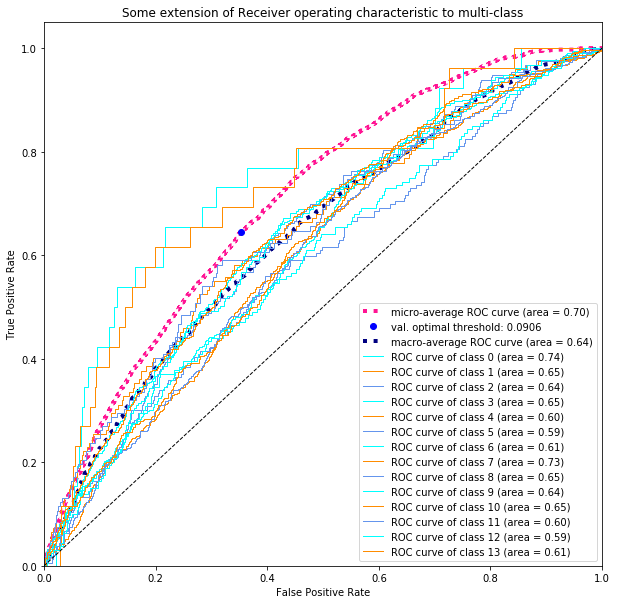

In [187]:
# Compute ROC curve and ROC area for each class
lw=1
n_classes=14

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_ohe[:, i], y_pred_val[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], thres_micro = roc_curve(y_val_ohe.ravel(), y_pred_val.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

min_arg_val = np.argmin(euclid_distance(fpr["micro"], tpr["micro"], opt_point=(0,1)))
opt_thres_val = thres_micro[min_arg_val]

# Plot all ROC curves
plt.figure(figsize=(10,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)


plt.plot(fpr["micro"][min_arg_val], tpr["micro"][min_arg_val], 'bo', label=f'val. optimal threshold: {opt_thres_val:0.4f}')

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
    

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

# Evaluation

#### ROC Curve to determine threshold

In [39]:
y_pred_val = model.predict_proba(x_val)[:,1]
y_pred_test = model.predict_proba(x_test)[:,1]

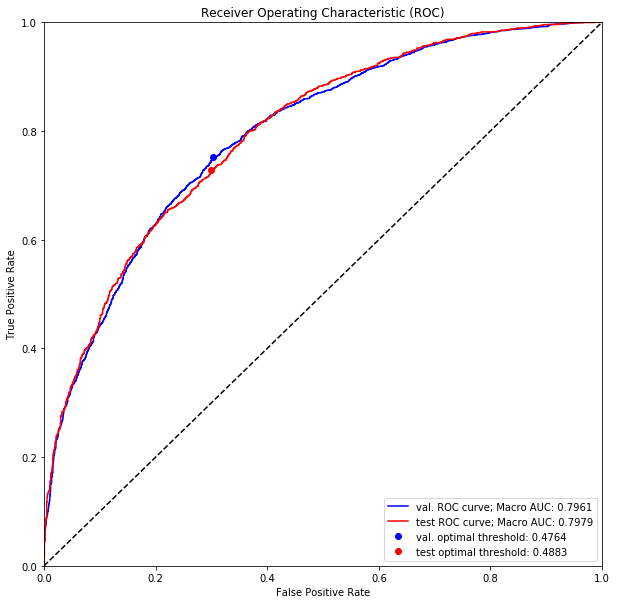

In [40]:
# Compute fpr, tpr, thresholds and roc auc
fpr_val, tpr_val, thresholds_val = roc_curve(y_val, y_pred_val)
mac_roc_auc_val = roc_auc_score(y_val, y_pred_val, average='macro')

fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_test)
mac_roc_auc_test = roc_auc_score(y_test, y_pred_test, average='macro')

#optimal threshold from ROC curve
#minimum euclid distance between (0,1) threshold points
min_arg_val = np.argmin(euclid_distance(fpr_val, tpr_val, opt_point=(0,1)))
opt_thres_val = thresholds_val[min_arg_val]

min_arg_test = np.argmin(euclid_distance(fpr_test, tpr_test, opt_point=(0,1)))
opt_thres_test = thresholds_test[min_arg_test]

# Plot ROC curve
plt.figure(figsize=(10,10))
plt.plot(fpr_val, tpr_val,'b', label=f'val. ROC curve; Macro AUC: {mac_roc_auc_val:0.4f}')
plt.plot(fpr_test, tpr_test, 'r', label=f'test ROC curve; Macro AUC: {mac_roc_auc_test:0.4f}')
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.plot(fpr_val[min_arg_val], tpr_val[min_arg_val], 'bo', label=f'val. optimal threshold: {opt_thres_val:0.4f}')
plt.plot(fpr_test[min_arg_test], tpr_test[min_arg_test], 'ro', label=f'test optimal threshold: {opt_thres_test:0.4f}')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [ ]:
y_pred_bin = y_pred > opt_thres

In [ ]:
print(accuracy_score(y_val, y_pred_bin))

#### Feature importance

In [348]:
#get feature columns
fcols = pid_dict['100644'].loc[:, 'ace_mean':].columns

In [349]:
feature_importance = pd.DataFrame()
fold_importance = pd.DataFrame()
fold_importance["feature"] = fcols
fold_importance["importance"] = model.feature_importances_
feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

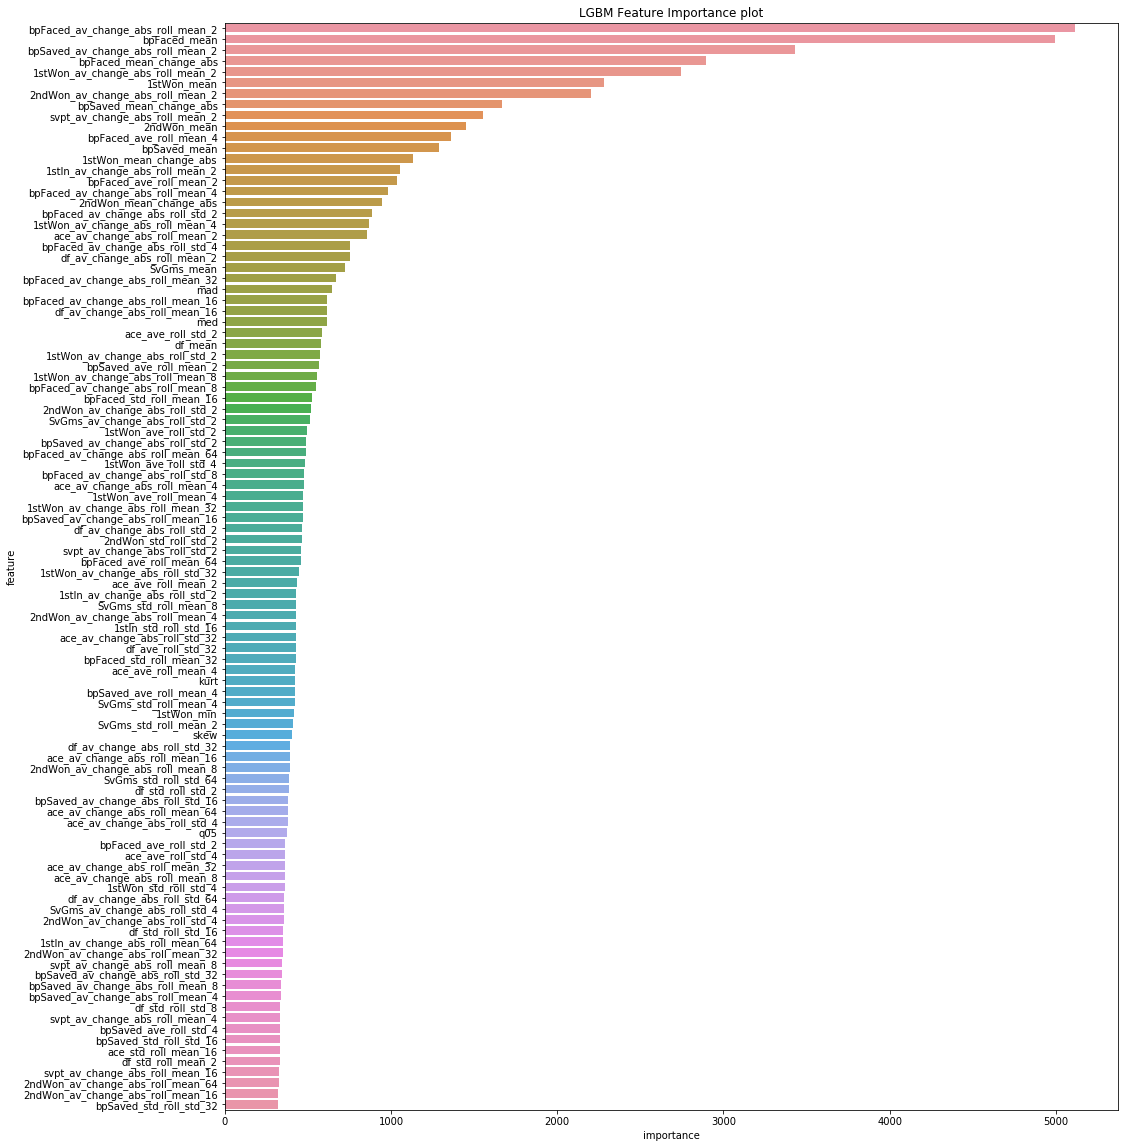

In [350]:
cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
            by="importance", ascending=False)[:100].index

best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

plt.figure(figsize=(16, 20));
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
plt.title('LGBM Feature Importance plot');

In [294]:
#get indices of top n columns (im choosing 50 here)
top_cols = np.argsort(-model.feature_importances_)[:100]

In [255]:
# Taking less columns seriously decreases score.
x_train_trim = x_train[:,top_cols]
x_val_trim = x_val[:,top_cols]

model = lgb.LGBMClassifier(**gs.best_params_,
                           n_estimators = 3000,
                           n_jobs = 6, 
                           objective='binary'
                           boosting='gbdt')

model.fit(x_train_trim, y_train[:,0],
          eval_set=[(x_train_trim, y_train[:,0]), (x_val_trim, y_val[:,0])],
          verbose=True)

[1]	valid_0's binary_logloss: 0.68312	valid_1's binary_logloss: 0.684475
[2]	valid_0's binary_logloss: 0.674537	valid_1's binary_logloss: 0.676375
[3]	valid_0's binary_logloss: 0.667217	valid_1's binary_logloss: 0.66941
[4]	valid_0's binary_logloss: 0.661748	valid_1's binary_logloss: 0.663917
[5]	valid_0's binary_logloss: 0.656132	valid_1's binary_logloss: 0.65851
[6]	valid_0's binary_logloss: 0.651161	valid_1's binary_logloss: 0.654379
[7]	valid_0's binary_logloss: 0.646984	valid_1's binary_logloss: 0.651203
[8]	valid_0's binary_logloss: 0.643133	valid_1's binary_logloss: 0.64819
[9]	valid_0's binary_logloss: 0.63973	valid_1's binary_logloss: 0.646053
[10]	valid_0's binary_logloss: 0.636597	valid_1's binary_logloss: 0.64381
[11]	valid_0's binary_logloss: 0.633848	valid_1's binary_logloss: 0.64166
[12]	valid_0's binary_logloss: 0.631385	valid_1's binary_logloss: 0.639265
[13]	valid_0's binary_logloss: 0.629149	valid_1's binary_logloss: 0.637206
[14]	valid_0's binary_logloss: 0.627073	v

LGBMClassifier(boosting='gbdt', boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.7496764148510038, importance_type='split',
               learning_rate=0.1, max_depth=-1, min_child_samples=260,
               min_child_weight=0.01, min_data_in_leaf=144, min_split_gain=0.0,
               n_estimators=3000, n_jobs=6, num_leaves=43, objective='binary',
               random_state=None, reg_alpha=7, reg_lambda=100, silent=True,
               subsample=0.48389072037616415, subsample_for_bin=200000,
               subsample_freq=0)

In [256]:
y_pred = model.predict(x_val_trim)
# y_pred = np.expand_dims(y_pred, axis=-1)

In [257]:
print(accuracy_score(y_val, y_pred))

0.6338709677419355


## Real match prediction

#### first retrain model on all data so that its updated on all current player information

In [43]:
#ALL ROWS of full dataframe
dev_rows = df.shape[0]

#number of statistical measures taken across features
num_stats = pid_dict['100644'].shape[1]-3

### iterate throught the main dataframe to link up player-ids
### and pull information from the respective dictionary index to form input-target pairs
x_train_dev = np.empty(shape=(int(dev_rows*2), num_stats))
y_train_dev = np.empty(shape=(int(dev_rows*2), 1))

### get features from whether the target player won or lost
df = df.sort_values(['tourney_date', 'match_num'], ascending=[True, True])

#initialize counters
j = 0

#loop through each row in the original dataframe
for winner_id, loser_id, tdate, match_num in tqdm_notebook(zip(df.winner_id.values, df.loser_id.values, df.tourney_date.values, df.match_num.values)):
    
    #extract features from player maps
    features_w = np.asarray(pid_dict[f'{winner_id}'].loc[(pid_dict[f'{winner_id}']['tourney_date'] == tdate) & (pid_dict[f'{winner_id}']['match_num'] == match_num)].loc[:, 'ace_mean':])[:1,:]
    features_l = np.asarray(pid_dict[f'{loser_id}'].loc[(pid_dict[f'{loser_id}']['tourney_date'] == tdate) & (pid_dict[f'{loser_id}']['match_num'] == match_num)].loc[:, 'ace_mean':])[:1,:]

    ### add to x_train_dev array
    #diff the features from winner to loser and count as a win
    x_train_dev[j,:] = features_w - features_l
    y_train_dev[j,0] = 1.0

    #diff the features from loser to winner and count as a loss
    x_train_dev[j+1,:] = features_l - features_w
    y_train_dev[j+1,0] = 0.0

    #increment counter
    j+=2

In [261]:

#ALL ROWS of full dataframe
dev_rows = df.shape[0]

#number of statistical measures taken across features
num_stats = pid_dict['100644'].shape[1]-3

### iterate throught the main dataframe to link up player-ids
### and pull information from the respective dictionary index to form input-target pairs
x_train_dev = np.empty(shape=(int(dev_rows*2), num_stats))
y_train_dev = np.empty(shape=(int(dev_rows*2), 1))

### get features from whether the target player won or lost
df = df.sort_values(['tourney_date', 'match_num'], ascending=[True, True])

#initialize counters
j = 0

#first round enum
first_round=0

invalid_scores = []

#loop through each row in the original dataframe
for score, winner_id, loser_id, tdate, match_num in tqdm_notebook(zip(df.score.values, df.winner_id.values, df.loser_id.values, df.tourney_date.values, df.match_num.values)):
    
    #extract features from player maps
    features_w = np.asarray(pid_dict[f'{winner_id}'].loc[(pid_dict[f'{winner_id}']['tourney_date'] == tdate) & (pid_dict[f'{winner_id}']['match_num'] == match_num)].loc[:, 'ace_mean':])[:1,:]
    features_l = np.asarray(pid_dict[f'{loser_id}'].loc[(pid_dict[f'{loser_id}']['tourney_date'] == tdate) & (pid_dict[f'{loser_id}']['match_num'] == match_num)].loc[:, 'ace_mean':])[:1,:]

#     print(score)
    
    #get multiclass targets
    try:
        score = str(score)
        score1, score2 = score.split(' ')[first_round].split('-')
        if score1 > score2:
            winner_first_set_score = score1
            loser_first_set_score = score2
        else:
            winner_first_set_score = score2
            loser_first_set_score = score1

        if '(' in loser_first_set_score:
            loser_first_set_score = loser_first_set_score[:1]                                 
        if '(' in winner_first_set_score:
            winner_first_set_score = winner_first_set_score[:1]

        winner_first_set_score = np.asarray(winner_first_set_score, dtype=np.int32)
        loser_first_set_score = np.asarray(loser_first_set_score, dtype=np.int32)
        
        ### add to x_train array
        #diff the features from winner to loser and count as a win
        x_train_dev[j,:] = features_w - features_l
        y_train_dev[j,0] = get_cate_val(winner_first_set_score, loser_first_set_score, winner_entry=True)

        #diff the features from loser to winner and count as a loss
        x_train_dev[j+1,:] = features_l - features_w
        y_train_dev[j+1,0] = get_cate_val(winner_first_set_score, loser_first_set_score, winner_entry=False)

        #increment counter
        j+=2

    except(ValueError):
        ### add to x_train array
        #diff the features from winner to loser and count as a win
        x_train_dev[j,:] = features_w - features_l
        y_train_dev[j,0] = -1

        #diff the features from loser to winner and count as a loss
        x_train_dev[j+1,:] = features_l - features_w
        y_train_dev[j+1,0] = -1

        #increment counter
        j+=2

        invalid_scores.append(score)
        continue

In [262]:
len(invalid_scores)

314

In [264]:
x_train_dev = np.delete(x_train_dev, np.argwhere(y_train_dev[:,0] == -1), axis=0)


In [265]:
y_train_dev = np.delete(y_train_dev, np.argwhere(y_train_dev[:,0] == -1), axis=0)


In [ ]:
model_dev = lgb.LGBMClassifier(#**gs.best_params_,
                               **params,
                               n_estimators = 5000,
                               n_jobs = 6, 
                               objective='binary',
                               boosting='gbdt')

model_dev.fit(x_train_dev, y_train_dev[:,0],
              eval_set=[(x_train_dev, y_train_dev[:,0])],
              verbose=True,
              early_stopping_rounds=250)

In [267]:
model_dev = lgb.LGBMClassifier(**params,
                               n_estimators = 100,
                               n_jobs = 6, 
                               boosting='gbdt')

model_dev.fit(x_train_dev, y_train_dev[:,0],
              eval_set=[(x_train_dev, y_train_dev[:,0])],
              verbose=True,
              early_stopping_rounds=250)

[1]	valid_0's multi_logloss: 2.48492
Training until validation scores don't improve for 250 rounds
[2]	valid_0's multi_logloss: 2.48385
[3]	valid_0's multi_logloss: 2.48278
[4]	valid_0's multi_logloss: 2.48171
[5]	valid_0's multi_logloss: 2.48065
[6]	valid_0's multi_logloss: 2.4796
[7]	valid_0's multi_logloss: 2.47855
[8]	valid_0's multi_logloss: 2.47752
[9]	valid_0's multi_logloss: 2.4765
[10]	valid_0's multi_logloss: 2.47546
[11]	valid_0's multi_logloss: 2.47444
[12]	valid_0's multi_logloss: 2.47345
[13]	valid_0's multi_logloss: 2.47246
[14]	valid_0's multi_logloss: 2.47146
[15]	valid_0's multi_logloss: 2.47049
[16]	valid_0's multi_logloss: 2.4695
[17]	valid_0's multi_logloss: 2.46853
[18]	valid_0's multi_logloss: 2.46757
[19]	valid_0's multi_logloss: 2.46662
[20]	valid_0's multi_logloss: 2.46568
[21]	valid_0's multi_logloss: 2.46472
[22]	valid_0's multi_logloss: 2.46377
[23]	valid_0's multi_logloss: 2.46282
[24]	valid_0's multi_logloss: 2.46189
[25]	valid_0's multi_logloss: 2.46095


LGBMClassifier(boosting='gbdt', boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.7496764148510038, importance_type='split',
               learning_rate=0.01, max_depth=-1, min_child_samples=260,
               min_child_weight=0.01, min_data_in_leaf=144, min_split_gain=0.0,
               n_estimators=100, n_jobs=6, num_class=14, num_leaves=43,
               objective='multiclass', random_state=None, reg_alpha=7,
               reg_lambda=100, silent=True, subsample=0.48389072037616415,
               subsample_for_bin=200000, subsample_freq=0)

#### Interact here!

In [64]:
# playerA_first_name, playerA_last_name = input("Enter Player 1 [first name(s), last name(s)]: ").split(',')
# playerB_first_name, playerB_last_name = input("Enter Player 2 [first name(s), last name(s)]: ").split(',')

# playerA_first_name = playerA_first_name.capitalize()
# playerA_last_name = playerA_last_name.capitalize()
# playerB_first_name = playerB_first_name.capitalize()
# playerB_last_name = playerB_last_name.capitalize()


Enter Player 1 [first name(s), last name(s)]:  taylor harry, fritz
Enter Player 2 [first name(s), last name(s)]:  test, test test


In [329]:
#round of 16

#real first round score: 6-2
#predicted: 6-3
playerA_first_name, playerA_last_name = 'Rafael', 'Nadal' #correct
playerB_first_name, playerB_last_name = 'Miomir', 'Kecmanovic'

#real first round score: 6-4
#predicted: 6-3
playerA_first_name, playerA_last_name = 'Stanislas', 'Wawrinka' #correct
playerB_first_name, playerB_last_name = 'Pedro', 'Martinez Portero'

#real first round score: 4-6
#predicted: 3-6
playerA_first_name, playerA_last_name = 'Ugo', 'Humbert' #correct
playerB_first_name, playerB_last_name = 'Taylor Harry', 'Fritz'
 
#real first round score: 7-6
#predicted: 3-6
playerA_first_name, playerA_last_name = 'Adrian', 'Mannarino' #correct
playerB_first_name, playerB_last_name = 'Grigor', 'Dimitrov'

#real first round score: 6-3
#predicted: 3-6
playerA_first_name, playerA_last_name = 'Tommy', 'Paul' #correct
playerB_first_name, playerB_last_name = 'Alexander', 'Zverev'

#real first round score: 6-3
#predicted: 6-4
playerA_first_name, playerA_last_name = 'John', 'Isner' #correct
playerB_first_name, playerB_last_name = 'Marcos', 'Giron'

#real first round score: 7-6
#pred: 4-6
playerA_first_name, playerA_last_name = 'Soon Woo', 'Kwon' #correct
playerB_first_name, playerB_last_name = 'Dusan', 'Lajovic'

#real: 6-4
#prd: 6-4
playerA_first_name, playerA_last_name = 'Kyle', 'Edmund' #incorrect
playerB_first_name, playerB_last_name = 'Felix', 'Auger Aliassime'

# #Mexican Open quarter finals

#real: 6-2
#pred: 6-3
playerA_first_name, playerA_last_name = 'Rafael', 'Nadal'  #correct
playerB_first_name, playerB_last_name = 'Soon Woo', 'Kwon'

#real: 6-4
#pred: 4-6
playerA_first_name, playerA_last_name = 'Taylor Harry', 'Fritz' #correct
playerB_first_name, playerB_last_name = 'Kyle', 'Edmund'

# #real: 4-6
# #pred: 3-6
# playerA_first_name, playerA_last_name = 'Stanislas', 'Wawrinka' #incorrect
# playerB_first_name, playerB_last_name = 'Grigor', 'Dimitrov'

# #real: 7-6
# #pred: 6-3
# playerA_first_name, playerA_last_name = 'John', 'Isner' #correct
# playerB_first_name, playerB_last_name = 'Tommy', 'Paul'

# # #Mexican Open semi finals

# #real: 6-3
# #pred: 6-3
# playerA_first_name, playerA_last_name = 'Rafael', 'Nadal' #correct
# playerB_first_name, playerB_last_name = 'Grigor', 'Dimitrov'

# #real: 6-2
# #pred: 6-3
# playerA_first_name, playerA_last_name = 'John', 'Isner'  #incorrect
# playerB_first_name, playerB_last_name = 'Taylor Harry', 'Fritz'

# # #Mexican Open finals

# #real: 6-3
# #pred: 6-4
# playerA_first_name, playerA_last_name = 'Rafael', 'Nadal' #correct
# playerB_first_name, playerB_last_name = 'Taylor Harry', 'Fritz'

#__________________
# 12 / 15 correct: 80% accurate
#__________________

#other

#real: 5-7
#pred: 6-3
# playerA_first_name, playerA_last_name = 'Casper', 'Ruud' #incorrect
# playerB_first_name, playerB_last_name = 'Thiago', 'Seyboth Wild'

# playerA_first_name, playerA_last_name = 'Arthur', 'Rinderknech'
# playerB_first_name, playerB_last_name = 'Maxime', 'Cressy'

In [330]:
playerA_id = find_id(playerA_first_name, playerA_last_name)
playerB_id = find_id(playerB_first_name, playerB_last_name)

#most recent player A/B tournament date:
tdateA, match_numA = np.asarray(pid_dict[f'{playerA_id}'][['tourney_date', 'match_num']])[-1]
tdateB, match_numB = np.asarray(pid_dict[f'{playerB_id}'][['tourney_date', 'match_num']])[-1]

#gather features from player profile dictionaries
features_a = np.asarray(pid_dict[f'{playerA_id}'].loc[(pid_dict[f'{playerA_id}']['tourney_date'] == tdateA) & (pid_dict[f'{playerA_id}']['match_num'] == match_numA)].loc[:, 'ace_mean':])
features_b = np.asarray(pid_dict[f'{playerB_id}'].loc[(pid_dict[f'{playerB_id}']['tourney_date'] == tdateB) & (pid_dict[f'{playerB_id}']['match_num'] == match_numB)].loc[:, 'ace_mean':])

#diff the features from a to b
x_dev = np.concatenate((features_a - features_b, features_b - features_a), axis=0)

In [331]:
y_pred_dev = model_dev.predict_proba(x_dev)
# y_pred_dev = model.predict_proba(x_dev)
y_pred_dev

array([[0.01077878, 0.04752248, 0.06733302, 0.12101209, 0.12456209,
        0.04908129, 0.09647716, 0.01021933, 0.03871605, 0.06173357,
        0.10656076, 0.12152801, 0.04351901, 0.10095636],
       [0.01038872, 0.03888816, 0.05908057, 0.10886789, 0.12082974,
        0.04355699, 0.09971915, 0.01050821, 0.04776061, 0.06842182,
        0.12103113, 0.12518077, 0.0499456 , 0.09582064]])

In [332]:
y_pred_dev = np.argmax(y_pred_dev, axis=1)
y_pred_dev

array([ 4, 11])

In [241]:
playerA_win_mean = np.mean([y_pred_dev[0][1], y_pred_dev[1][0]])
playerA_win_stdev = np.std([y_pred_dev[0][1], y_pred_dev[1][0]])

playerB_win_mean = np.mean([y_pred_dev[1][1], y_pred_dev[0][0]])
playerB_win_stdev = np.std([y_pred_dev[1][1], y_pred_dev[0][0]])

print(f"Probability that {playerA_first_name} {playerA_last_name} wins: {playerA_win_mean*100:0.2f} ± {playerA_win_stdev*100:0.2f}%")
print(f"Probability that {playerB_first_name} {playerB_last_name} wins: {playerB_win_mean*100:0.2f} ± {playerB_win_stdev*100:0.2f}%")
print(f"\nwhere optimal validation-set derived threshold = {opt_thres_val:0.4f}")

Probability that Casper Ruud wins: 73.29 ± 0.14%
Probability that Thiago Seyboth Wild wins: 26.71 ± 0.14%

where optimal validation-set derived threshold = 0.4764


In [379]:
del x_train_dev
del y_train_dev

In [90]:
players.loc[(players['last_name'] == 'Rinderknech')]
# players.loc[(players['first_name'] == 'Dusan')]

,player_id,first_name,last_name,hand,birthday,country_code
13026,113042,Pierre,Rinderknech,NaN,NaN,FRA
26223,126239,Arthur,Rinderknech,U,19950723.0,FRA


In [ ]:
arthur rinderknech

### Function defs

In [54]:
def extract_stats(df, segments, features):

    #main dataframe for storing stats
    X_tr = pd.DataFrame(index=range(segments), dtype=np.float64)
    
    for feature in features:
        
#         if feature == 'age':
#         X_tr.loc[segment, f'age'] = x_full[:segment+1].mean()
    
        #time series data
        x_full = pd.Series(df[f'{feature}'].values)
        feature_name = feature[2:]
    
        for segment in range(segments):
            #take all of x until that point in time
            x = x_full[:segment+1]
            
            #personal stats
            if feature_name == 'age':
                X_tr.loc[segment, f'{feature_name}'] = x_full[segment]
            elif feature_name == 'height':
                X_tr.loc[segment, f'{feature_name}'] = x_full[segment]
            elif feature_name == 'hand':
                if x_full[segment] == 'R':
                    X_tr.loc[segment, f'{feature_name}'] = 1
                elif x_full[segment] == 'L':
                    X_tr.loc[segment, f'{feature_name}'] = 2
                else:
                    X_tr.loc[segment, f'{feature_name}'] = 0
            else:

                #compute stats on this feature
                X_tr.loc[segment, f'{feature_name}_mean'] = x.mean()
                X_tr.loc[segment, f'{feature_name}_std'] = x.std()
                X_tr.loc[segment, f'{feature_name}_max'] = x.max()
                X_tr.loc[segment, f'{feature_name}_min'] = x.min()

                X_tr.loc[segment, f'{feature_name}_mean_change_abs'] = np.mean(np.diff(x))
                X_tr.loc[segment, f'{feature_name}_abs_max'] = np.abs(x).max()
                X_tr.loc[segment, f'{feature_name}_abs_min'] = np.abs(x).min()

                X_tr.loc[segment, 'max_to_min_diff'] = x.max() - np.abs(x.min())
                X_tr.loc[segment, 'sum'] = x.sum()

                X_tr.loc[segment, 'q95'] = np.quantile(x, 0.95)
                X_tr.loc[segment, 'q99'] = np.quantile(x, 0.99)
                X_tr.loc[segment, 'q05'] = np.quantile(x, 0.05)
                X_tr.loc[segment, 'q01'] = np.quantile(x, 0.01)

                X_tr.loc[segment, 'abs_q95'] = np.quantile(np.abs(x), 0.95)
                X_tr.loc[segment, 'abs_q99'] = np.quantile(np.abs(x), 0.99)
                X_tr.loc[segment, 'abs_q05'] = np.quantile(np.abs(x), 0.05)
                X_tr.loc[segment, 'abs_q01'] = np.quantile(np.abs(x), 0.01)

    #########################
            #     X_tr.loc[segment, 'trend'] = add_trend_feature(x)
            #     X_tr.loc[segment, 'abs_trend'] = add_trend_feature(x, abs_values=True)
            #     X_tr.loc[segment, 'abs_mean'] = np.abs(x).mean()
            #     X_tr.loc[segment, 'abs_std'] = np.abs(x).std()
    #######################
                X_tr.loc[segment, 'mad'] = x.mad()
                X_tr.loc[segment, 'kurt'] = x.kurtosis()
                X_tr.loc[segment, 'skew'] = x.skew()
                X_tr.loc[segment, 'med'] = x.median()

                #rolling stats
                for windows in [2, 4, 8, 16, 32, 64]:
                    x_roll_std = x.rolling(windows).std().dropna().values
                    x_roll_mean = x.rolling(windows).mean().dropna().values

                    X_tr.loc[segment, f'{feature_name}_ave_roll_std_' + str(windows)] = x_roll_std.mean()
                    X_tr.loc[segment, f'{feature_name}_std_roll_std_' + str(windows)] = x_roll_std.std()
                    X_tr.loc[segment, f'{feature_name}_av_change_abs_roll_std_' + str(windows)] = np.mean(np.diff(x_roll_std))
                    X_tr.loc[segment, f'{feature_name}_av_change_rate_roll_std_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_std) / x_roll_std[:-1]))[0])

                    X_tr.loc[segment, f'{feature_name}_ave_roll_mean_' + str(windows)] = x_roll_mean.mean()
                    X_tr.loc[segment, f'{feature_name}_std_roll_mean_' + str(windows)] = x_roll_mean.std()
                    X_tr.loc[segment, f'{feature_name}_av_change_abs_roll_mean_' + str(windows)] = np.mean(np.diff(x_roll_mean))
                    X_tr.loc[segment, f'{feature_name}_av_change_rate_roll_mean_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_mean) / x_roll_mean[:-1]))[0])

    #fill all NaN values with 0
    X_tr = X_tr.fillna(value=0.0)
    
    return X_tr

In [55]:
def find_id(first_name, last_name):
    return np.asarray(players.loc[(players['last_name'] == last_name) & (players['first_name'] == first_name)]['player_id'])[0]

In [56]:
def euclid_distance(x,y, opt_point=(0,1)):
    return np.sqrt((opt_point[1] - y)**2 + (opt_point[0] - x)**2)